**Aspect Extraction Using TF-IDF Method**<br>
**Sentiment Analysis Using Vader**<br>
**Aspect-Based Sentiment using BART**<br>

In [9]:
import spacy
import json
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# # Load Sentiment Analysis Tools
# sia = SentimentIntensityAnalyzer()
# aspect_pipeline = pipeline("text-classification", model="facebook/bart-large-mnli")

# Load Data
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten JSON Data
flattened_data = []
for channel, playlists in data.items():
    for playlist_id, videos in playlists.items():
        for video_id, video_data in videos.items():
            for comment in video_data.get('comments', []):
                flattened_data.append({
                    "channel": channel,
                    "video_id": video_id,
                    "video_title": video_data.get("video_title", ""),
                    "timestamp": comment["Timestamp"],
                    "comment": comment["Comment"]
                })

df = pd.DataFrame(flattened_data)


In [11]:
# Define extended stopwords
custom_stopwords = set(stopwords.words('english') + ['like', 'love', 'good', 'great', 'video', 'dont', 'guys', 'want', 'need', \
                                                     'car', 'cars', 'buy', 'thanks','people', 'im', 'think', 'make','really', 'elon', 'work',\
                                                      'thank', 'nice','know', 'going', 'way', 'years', 'new', 'charge', 'better'])

# # Preprocess Comments
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r'http\S+', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
#     text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
#     return text.strip()

# df["cleaned_text"] = df["comment"].apply(clean_text)

# Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])  # Use custom stopwords
    return text.strip()

df["cleaned_text"] = df["comment"].apply(clean_text)

# Function to extract aspects using dependency parsing
def extract_aspects_nlp(text):
    doc = nlp(text)
    aspects = []
    
    for chunk in doc.noun_chunks:  # Extract noun phrases
        if chunk.root.dep_ in ["nsubj", "dobj", "pobj"]:  # Ensure it's a relevant noun phrase
            aspects.append(chunk.text.lower())
    
    return aspects

# Function to extract top aspects using TF-IDF
def extract_top_aspects_tfidf(comments, top_n=10):
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 5))   # ADJUSTED
    tfidf_matrix = vectorizer.fit_transform(comments)
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top-ranked words/phrases based on TF-IDF scores
    scores = tfidf_matrix.sum(axis=0).A1
    aspect_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)
    
    return [aspect for aspect, score in aspect_scores[:top_n]]

df.dropna(subset=["cleaned_text"], inplace=True)  # Remove rows with missing comments
df["extracted_aspects"] = df["cleaned_text"].apply(extract_aspects_nlp)

# Extract top-ranked aspects using TF-IDF
top_aspects = extract_top_aspects_tfidf(df["cleaned_text"].tolist())

In [12]:
# Print extracted top aspects for debugging
print("Top Aspects from TF-IDF:", top_aspects)

Top Aspects from TF-IDF: ['tesla', 'ev', 'electric', 'battery', 'looks', 'time', 'charging', 'range', 'price', 'use']


In [ ]:
# # Sentiment Analysis using VADER
# def get_sentiment(text):
#     scores = sia.polarity_scores(text)
#     if scores["compound"] > 0.05:
#         return "positive"
#     elif scores["compound"] < -0.05:
#         return "negative"
#     else:
#         return "neutral"

# df["sentiment_vader"] = df["cleaned_text"].apply(get_sentiment)

# # Aspect-Based Sentiment using BART
# # def get_aspect_sentiment(text):
# #     if not text:
# #         return "neutral"
# #     result = aspect_pipeline(text)[0]["label"]
# #     return result.lower()

# def get_aspect_sentiment(text):
#     if not text:
#         return "neutral"
#     result = aspect_pipeline(text)[0]["label"]
    
#     # Map NLI labels to sentiment labels
#     sentiment_map = {
#         "entailment": "positive",
#         "neutral": "neutral",
#         "contradiction": "negative"
#     }
    
#     return sentiment_map.get(result.lower(), "neutral")

# df["aspect_sentiment_bart"] = df["cleaned_text"].apply(get_aspect_sentiment)


# # 1️⃣ Extracted Aspects per Comment
# print("Extracted Aspects:", df["extracted_aspects"].head())

# # 2️⃣ Sentiment Analysis for Each Aspect
# print("Sentiment Analysis (VADER):", df["sentiment_vader"].head())
# print("Aspect-Based Sentiment (BART):", df["aspect_sentiment_bart"].head())

# # 3️⃣ Aspect-Based Sentiment Comparison Among Creators
# # Summarize sentiment distribution per creator
# sentiment_counts = df.groupby(['channel', 'sentiment_vader']).size().unstack(fill_value=0)
# sentiment_counts = sentiment_counts[['positive', 'neutral', 'negative']]  # Ensure the correct order

Extracted Aspects: 0                                        [hi guy, buy]
1    [still electric car, prices, big question, bat...
2                                                   []
3                                                   []
4        [latin american country, cars, cars, vietnam]
Name: extracted_aspects, dtype: object
Sentiment Analysis (VADER): 0    positive
1    negative
2    negative
3    positive
4    negative
Name: sentiment_vader, dtype: object
Aspect-Based Sentiment (BART): 0    neutral
1    neutral
2    neutral
3    neutral
4    neutral
Name: aspect_sentiment_bart, dtype: object


In [ ]:
# # 1️⃣ Extracted Aspects per Comment
# print("Extracted Aspects:", df["extracted_aspects"])

Extracted Aspects: 0                                            [hi guy, buy]
1        [still electric car, prices, big question, bat...
2                                                       []
3                                                       []
4            [latin american country, cars, cars, vietnam]
                               ...                        
51725    [bevs, stick fork hybrids, bevs future, anxiet...
51726                        [home, charge best batteries]
51727                                               [lack]
51728                                                   []
51729     [good video advice alex thank, vancouver canada]
Name: extracted_aspects, Length: 51730, dtype: object


The full pipeline:

Loads a fine-tuned RoBERTa sentiment model

Predicts sentiment for each cleaned comment

Adds those predictions to your DataFrame

In [16]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("fine-tuned-roberta-triplet-classification").to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("fine-tuned-roberta-triplet-classification")

In [17]:
def predict_sentiment(text):
    # Tokenize the text and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(model.device)

    # Get the model's prediction (logits)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted class index (use argmax directly on logits)
    sentiment_class = torch.argmax(logits, dim=1).item()

    # Map the class index to sentiment label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment = sentiment_labels[sentiment_class]

    return sentiment

# Apply the function to the cleaned text in your DataFramec
df["sentiment_roberta"] = df["cleaned_text"].apply(predict_sentiment)

# Example to see the new DataFrame with the predicted sentiment
print(df[["comment", "sentiment_roberta"]].head())

                                             comment sentiment_roberta
0  hi.  so you Guy proud of it please prove by buy 1          Positive
1  Tesla still the electric car to beat especiall...          Negative
2                            This didn’t age well……😂          Negative
3                  Good luck VIETNAMESE Electric Car          Positive
4  Why can't Mexico or any Latin American country...          Positive


In [18]:
df.to_csv("comment_sentiment_roberta_PLP3.csv", index=False)

**ROBERTA: Overall Sentiment Distribution Per Creator**

In [19]:
# Aspect-Based Sentiment Comparison Among Creators
# Summarize sentiment distribution per creator
sentiment_counts = df.groupby(['channel', 'sentiment_roberta']).size().unstack(fill_value=0)
sentiment_counts = sentiment_counts[['Positive', 'Neutral', 'Negative']]  # Ensure the correct order

In [20]:
sentiment_df_roberta_TDIDF = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df_roberta_TDIDF.to_csv("sentiment_df_roberta_TDIDF.csv", index=False)

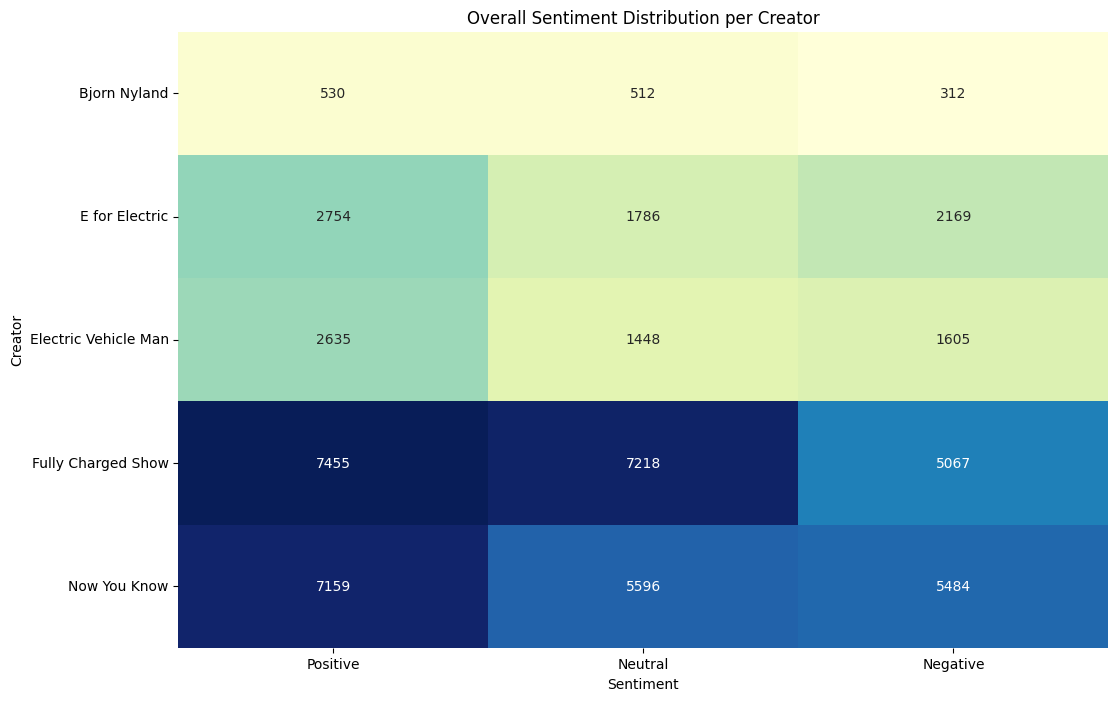

In [21]:
# Plot the heatmap for overall sentiment distribution per creator
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_counts, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title('Overall Sentiment Distribution per Creator')
plt.xlabel('Sentiment')
plt.ylabel('Creator')
plt.show()

In [22]:
print(df.columns)


Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment',
       'cleaned_text', 'extracted_aspects', 'sentiment_roberta'],
      dtype='object')


**VADER: Percentage of Positive Sentiment Per Aspect**

In [65]:
# # Convert top_aspects to a DataFrame if it is a list
# top_aspects_df = pd.DataFrame(top_aspects, columns=["Aspect"])

# # Initialize dictionary to store sentiment counts per creator
# sentiment_counts = {aspect: {} for aspect in top_aspects_df['Aspect']}  # Use the 'Aspect' column in the DataFrame

# # Process sentiment data
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
    
#     for aspect in top_aspects_df['Aspect']:  # Use 'Aspect' from the DataFrame
#         total_mentions = 0
#         positive_mentions = 0
        
#         for aspects, sentiment in zip(creator_df['extracted_aspects'], creator_df['sentiment_vader']):
#             if aspect in aspects:
#                 total_mentions += 1
#                 if sentiment == "positive":
#                     positive_mentions += 1
        
#         # Calculate positive sentiment percentage
#         sentiment_counts[aspect][creator] = f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"

# # Convert sentiment data to DataFrame
# sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
# sentiment_df.columns = ["Aspect"] + list(df["channel"].unique())

# # Plot the Table
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.axis("tight")
# ax.axis("off")

# # Create the table
# table = ax.table(cellText=sentiment_df.values, 
#                  colLabels=sentiment_df.columns, 
#                  cellLoc='center', 
#                  loc='center')

# # Style the Table
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# # Highlight header row
# for key, cell in table.get_celld().items():
#     if key[0] == 0:  # Header row
#         cell.set_text_props(weight='bold', color='white')
#         cell.set_facecolor("#2E74B5")  # Blue Header

# # Add title to the table
# plt.title("Positive Sentiment Percentage Per Aspect", fontsize=14, weight='bold')

# # Display the table
# plt.show()


**ROBERTA: Percentage of Positive Sentiment Per Aspect**

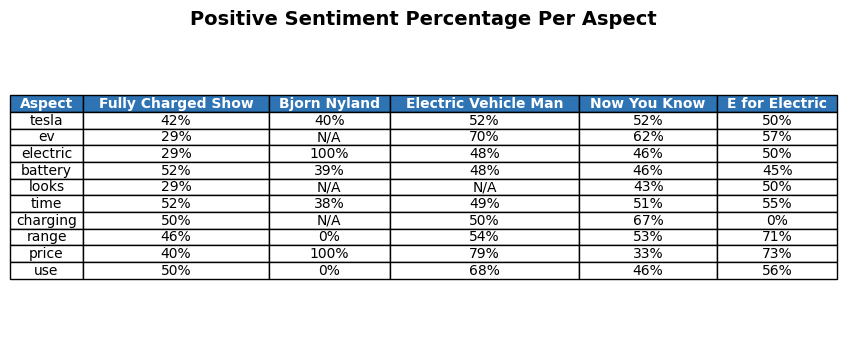

In [23]:
# Convert top_aspects to a DataFrame if it is a list
top_aspects_df = pd.DataFrame(top_aspects, columns=["Aspect"])

# Initialize dictionary to store sentiment counts per creator
sentiment_counts = {aspect: {} for aspect in top_aspects_df['Aspect']}  # Use the 'Aspect' column in the DataFrame

# Process sentiment data
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    
    for aspect in top_aspects_df['Aspect']:  # Use 'Aspect' from the DataFrame
        total_mentions = 0
        positive_mentions = 0
        
        for aspects, sentiment in zip(creator_df['extracted_aspects'], creator_df['sentiment_roberta']):
            if aspect in aspects:
                total_mentions += 1
                if sentiment == "Positive":
                    positive_mentions += 1
        
        # Calculate positive sentiment percentage
        sentiment_counts[aspect][creator] = f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"

# Convert sentiment data to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df.columns = ["Aspect"] + list(df["channel"].unique())

# Plot the Table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=sentiment_df.values, 
                 colLabels=sentiment_df.columns, 
                 cellLoc='center', 
                 loc='center')

# Style the Table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# Highlight header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor("#2E74B5")  # Blue Header

# Add title to the table
plt.title("Positive Sentiment Percentage Per Aspect", fontsize=14, weight='bold')

# Display the table
plt.show()


In [24]:
sentiment_df.to_csv("TD_IDF_sentiment_df_roberta.csv", index=True)

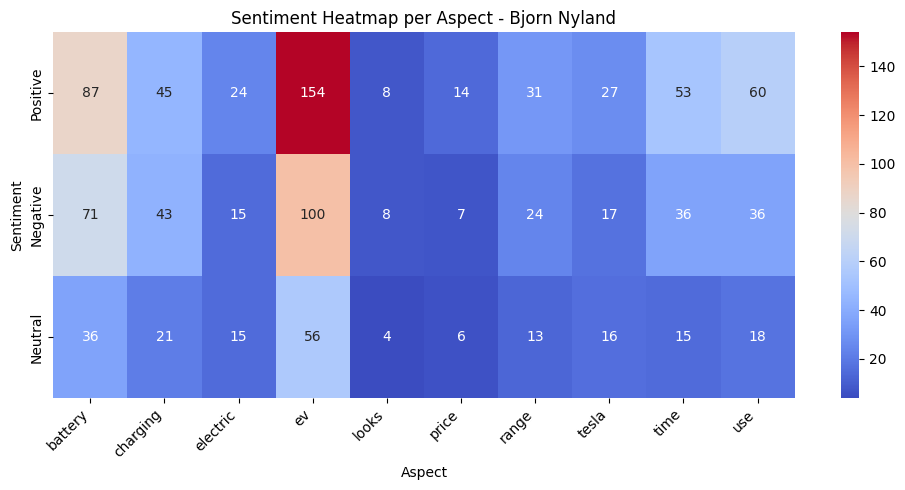

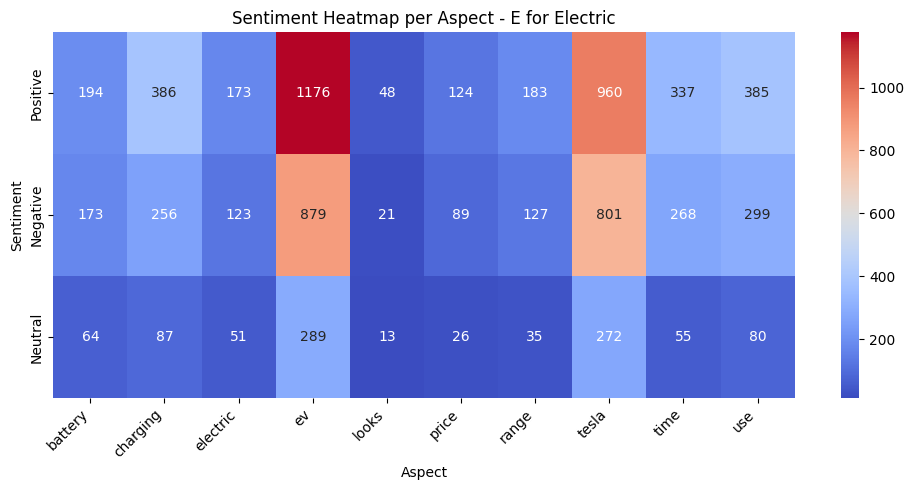

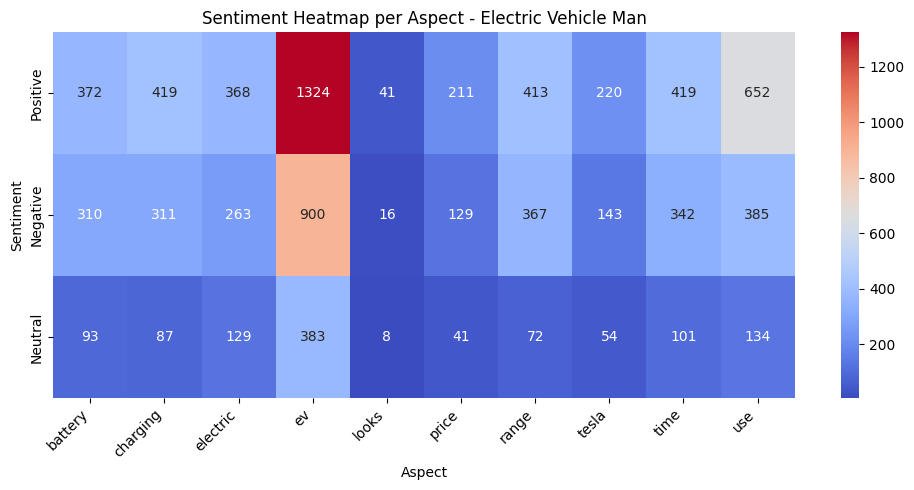

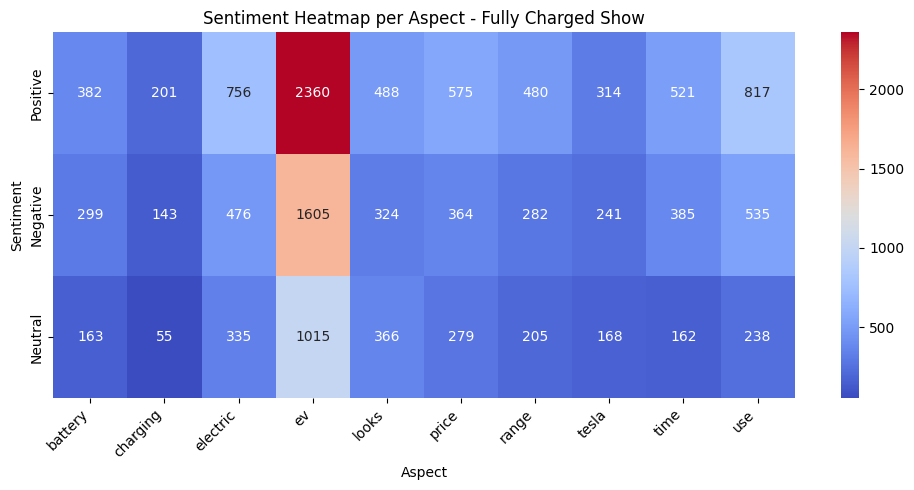

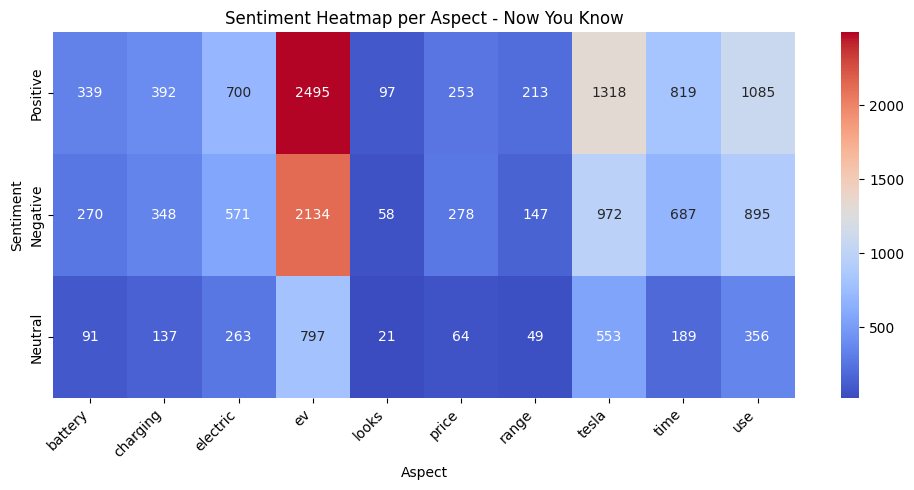

In [ ]:
#ABSA heatmap per channel

def find_matching_aspects(comment, top_aspects):
    return [aspect for aspect in top_aspects if aspect in comment.lower()]

df["matched_aspects"] = df["cleaned_text"].apply(lambda x: find_matching_aspects(x, top_aspects))


df_expanded = df.explode("matched_aspects")
df_expanded = df_expanded.dropna(subset=["matched_aspects"])  # Drop rows where no top aspect was matched

grouped = df_expanded.groupby(["channel", "matched_aspects", "sentiment_roberta"]).size().unstack(fill_value=0).reset_index()

for channel in grouped["channel"].unique():
    subset = grouped[grouped["channel"] == channel].set_index("matched_aspects")[["Positive", "Negative", "Neutral"]]
    plt.figure(figsize=(10, 5))
    sns.heatmap(subset.T, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Sentiment Heatmap per Aspect - {channel}")
    plt.ylabel("Sentiment")
    plt.xlabel("Aspect")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [26]:
grouped.to_csv("TD_IDF_topic_sentiment_per_creator_roberta.csv", index=True)

**VADER: Overall Heatmap per Creator: All Aspects Across their Videos**

In [77]:
# # Now, proceed with the explode function if extracted_aspects column exists
# for creator in df["channel"].unique():
#     if 'extracted_aspects' in df.columns:
#         creator_df = df[df["channel"] == creator].explode("extracted_aspects")
#         aspect_video_sentiment = creator_df.groupby(["video_id", "extracted_aspects", "sentiment_vader"]).size().unstack(fill_value=0)
#         plt.figure(figsize=(15, 8))
#         sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
#         plt.title(f"Aspect-Based Sentiment for {creator} Across Videos")
#         plt.xlabel("Sentiment")
#         plt.ylabel("Aspect")
#         plt.xticks(rotation=45)
#         #plt.ylim([min_limit, max_limit])  # Set the limits for the Y-axis
#         plt.show()
#     else:
#         print(f"Column 'extracted_aspects' not found for creator {creator}")

**VADER: Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)**

In [78]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Initialize an empty DataFrame to store the results
# aspect_sentiment_matrix = pd.DataFrame()

# # Iterate through each creator and calculate aspect sentiment for each video
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
#     creator_aspect_sentiment = []

#     for video_id in creator_df['video_id'].unique():
#         video_comments = creator_df[creator_df['video_id'] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Update sentiment counts for each aspect in each comment
#         for comment, sentiment in zip(video_comments['extracted_aspects'], video_comments['sentiment_vader']):
#             for aspect in comment:
#                 if aspect in aspect_sentiments:
#                     aspect_sentiments[aspect] += 1 if sentiment == "positive" else -1 if sentiment == "negative" else 0

#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Convert the creator_aspect_sentiment list to a DataFrame
#     creator_aspect_sentiment_df = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)

#     # Add the DataFrame for this creator to the main aspect_sentiment_matrix
#     aspect_sentiment_matrix[creator] = creator_aspect_sentiment_df.mean(axis=0)  # You can use mean or any other aggregation method


# # Plot the heatmap with float formatting
# plt.figure(figsize=(14, 10))
# sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
# plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)")
# plt.xlabel('Video')
# plt.ylabel('Creator')
# plt.xticks(rotation=45)
# plt.show()

**VADER: Heatmap per Creator Per Aspect Per Video (in one Heatmap)** 

In [79]:
# # Extract top-ranked aspects dynamically using TF-IDF
# top_aspects = extract_top_aspects_tfidf(df["cleaned_text"].tolist())

# # Print extracted top aspects for debugging
# print("Top Aspects from TF-IDF:", top_aspects)

# # Explode the extracted aspects column for proper analysis
# df_exploded = df.explode("extracted_aspects").dropna(subset=["extracted_aspects"])

# # Initialize a list to store aspect sentiment data for each creator and video
# aspect_sentiment_matrix = []

# # Loop through each creator
# for creator in df["channel"].unique():
#     creator_df = df_exploded[df_exploded["channel"] == creator]
#     creator_aspect_sentiment = []

#     # Loop through each video
#     for video_id in creator_df["video_id"].unique():
#         video_comments = creator_df[creator_df["video_id"] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Loop through each comment and its sentiment
#         for aspects, sentiment in zip(video_comments["extracted_aspects"], video_comments["sentiment_vader"]):
#             if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
#                 # Increment or decrement based on sentiment
#                 aspect_sentiments[aspects] += (
#                     1 if sentiment == "positive" else -1 if sentiment == "negative" else 0
#                 )

#         # Append sentiment values for this video
#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Convert the list into a DataFrame for this creator and append to matrix
#     creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)
#     aspect_sentiment_matrix.append(creator_df_sentiment)

# # Concatenate all creator sentiment matrices (horizontally) with labels
# aspect_sentiment_matrix = pd.concat(aspect_sentiment_matrix, axis=1, keys=df["channel"].unique())

# # Plot the overall aspect sentiment matrix
# plt.figure(figsize=(14, 10))
# #sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
# sns.heatmap(aspect_sentiment_matrix.T, annot=False, cmap="RdYlGn_r", fmt=".2f", cbar=True)
# plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row = Aspect, Each Column = Video)")
# plt.xlabel("Video")
# plt.ylabel("Creator")
# plt.show()


**VADER: Heatmap per Creator Per Aspect Per Video (One Heatmap Per Creator)** 

In [80]:
# # Ensure 'extracted_aspects' is a list before exploding
# df['extracted_aspects'] = df['extracted_aspects'].apply(lambda x: x if isinstance(x, list) else [x] if pd.notna(x) else [])

# # Explode the 'extracted_aspects' column
# df_exploded = df.explode("extracted_aspects")

# # Ensure 'extracted_aspects' remains a list
# df_exploded['extracted_aspects'] = df_exploded['extracted_aspects'].apply(lambda x: [x] if isinstance(x, str) and x else [])

# # Print to verify
# print(df_exploded[['channel','extracted_aspects', 'sentiment_vader']].head(10))

In [81]:
# # Initialize a matrix for storing aspect sentiment data for each creator and video
# aspect_sentiment_matrix = []

# # Loop through each creator
# for creator in df['channel'].unique():
#     creator_df = df_exploded[df_exploded['channel'] == creator]
#     creator_aspect_sentiment = []

#     # Loop through each video
#     for video_id in creator_df['video_id'].unique():
#         video_comments = creator_df[creator_df['video_id'] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Loop through each comment and its sentiment
#         for aspects, sentiment in zip(video_comments['extracted_aspects'], video_comments['sentiment_vader']):
#             for aspect in aspects:
#                 if aspect in aspect_sentiments:  # Ensure aspect is in top extracted aspects
#                     # Increment or decrement based on sentiment
#                     aspect_sentiments[aspect] += 1 if sentiment == "positive" else -1 if sentiment == "negative" else 0

#         # Append the sentiment values for this video
#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Add the creator's aspect sentiment data to the matrix
#     aspect_sentiment_matrix.append(creator_aspect_sentiment)

# # Convert the matrix into a DataFrame, ensuring each video has the same number of columns
# max_videos = max(len(creator_aspect_sentiment) for creator_aspect_sentiment in aspect_sentiment_matrix)

# # Fill with NaNs for creators with fewer videos
# for idx, creator_sentiment in enumerate(aspect_sentiment_matrix):
#     while len(creator_sentiment) < max_videos:
#         creator_sentiment.append([0] * len(top_aspects))  # Fill missing video rows with zeros

# # Convert into DataFrame, where each row corresponds to an aspect, and each column to a video
# aspect_sentiment_matrix_df = pd.DataFrame(aspect_sentiment_matrix, 
#                                           columns=[f"Video {i+1}" for i in range(max_videos)], 
#                                           index=df['channel'].unique())

# # Now plot for each creator's sentiment data
# for creator, sentiment_data in zip(df['channel'].unique(), aspect_sentiment_matrix):
#     creator_sentiment_df = pd.DataFrame(sentiment_data, columns=top_aspects)
    
#     # Plot the aspect sentiment for this specific creator
#     plt.figure(figsize=(14, 10))
#     #sns.heatmap(creator_sentiment_df.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
#     sns.heatmap(creator_sentiment_df.T, annot=False, cmap="RdYlGn_r", fmt=".2f", cbar=True)
#     plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row is an Aspect, Each Column is a Video)")
#     plt.xlabel('Video')
#     plt.ylabel('Aspect')
#     plt.show()

**Bar Plot: Total Number of Comments per Creator**

In [82]:
# total_comments = df["channel"].value_counts()
# plt.figure(figsize=(10, 5))
# sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")
# plt.title("Total Number of Comments per Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.show()


**Time Series: Number of Comments Over Time per Creator**

In [83]:
# # Time series of the number of comments received per creator
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['date'] = df['timestamp'].dt.date
# # comment_time_series = df.groupby(['date', 'channel']).size().unstack(fill_value=0)
# # comment_time_series.plot(figsize=(14, 8), title="Time Series of Comments per Creator")
# # plt.ylabel('Number of Comments')
# # plt.xlabel('Date')
# # plt.legend(title="Creator")
# # plt.show()

# comment_time_series = df.groupby(["date", "channel"]).size().unstack(fill_value=0)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=comment_time_series)
# plt.title("Number of Comments Over Time by Content Creator")
# plt.xlabel("Date")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.legend(title="Content Creator")
# plt.grid()
# plt.show()

**VADER: Bar Plot: Total Number of Positive Comments per Creator**

In [84]:
# # Count the number of positive comments per creator
# positive_comments_per_creator = df[df['sentiment_vader'] == 'positive'].groupby('channel').size()

# # Plotting the number of positive comments per creator
# plt.figure(figsize=(10, 5))
# sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
# plt.title("Positive Sentiment by Content Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Positive Comments")
# plt.xticks(rotation=45)
# plt.show()

In [85]:
# # Count the number of comments per sentiment per creator
# comments_per_creator_sentiment = df.groupby(['channel', 'sentiment_vader']).size().unstack(fill_value=0)

# # Plotting the number of comments per sentiment (Positive, Negative, Neutral) per creator
# comments_per_creator_sentiment.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="viridis")

# plt.title("Sentiment Distribution by Content Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

**VADER: Time Series: Number of Positive Comments Over Time per Creator**

In [86]:
# # Time series of the number of positive comments received per creator
# positive_comment_time_series = df[df['sentiment_vader'] == 'positive'].groupby(['date', 'channel']).size().unstack(fill_value=0)
# positive_comment_time_series.plot(figsize=(14, 8), title="Time Series of Positive Comments per Creator")
# plt.ylabel('Number of Positive Comments')
# plt.xlabel('Date')
# plt.legend(title="Creator")
# plt.show()

**ROBERTA: Overall Heatmap per Creator: All Aspects Across their Videos**

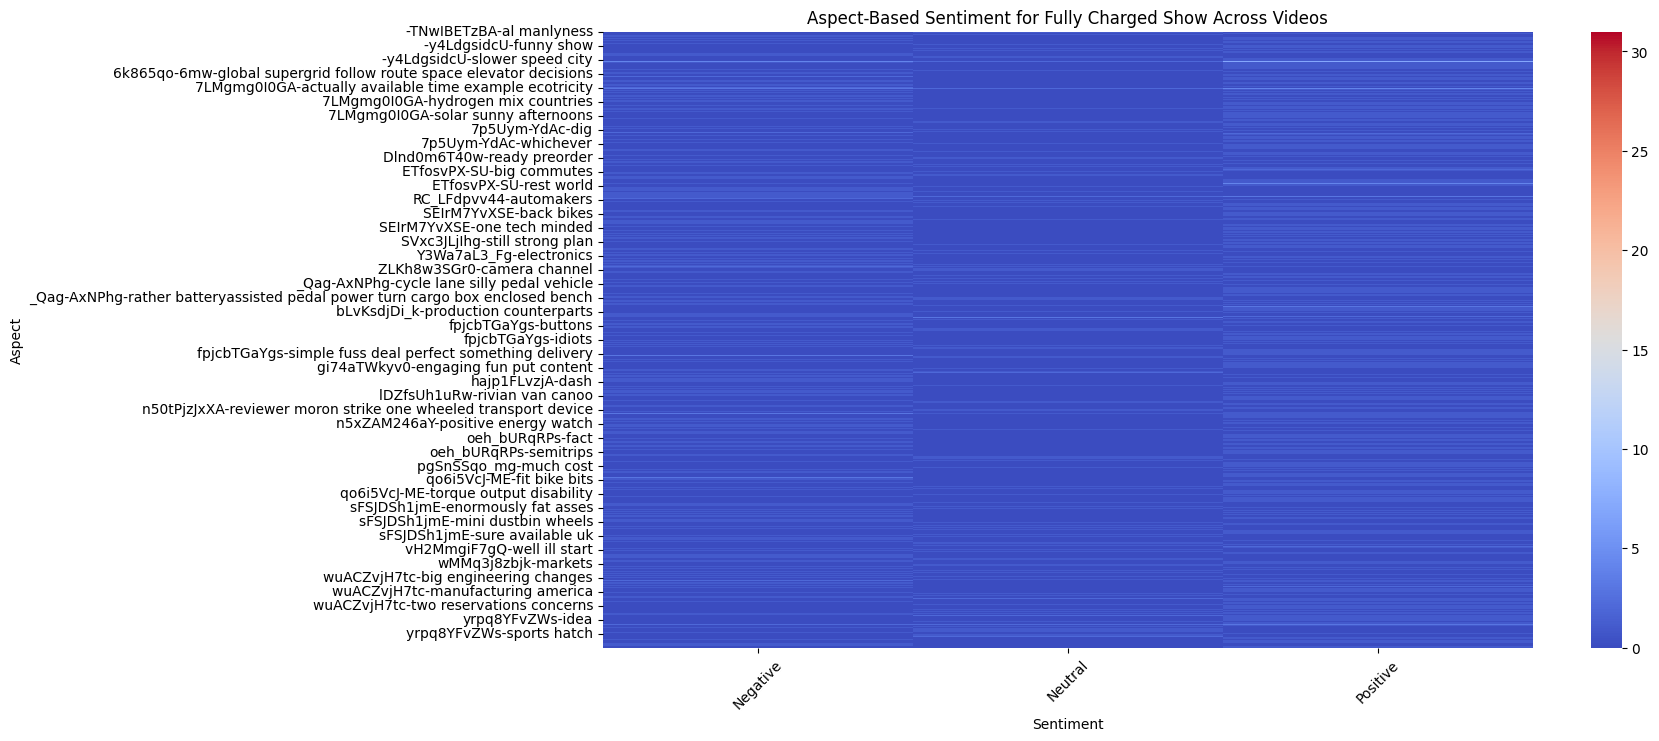

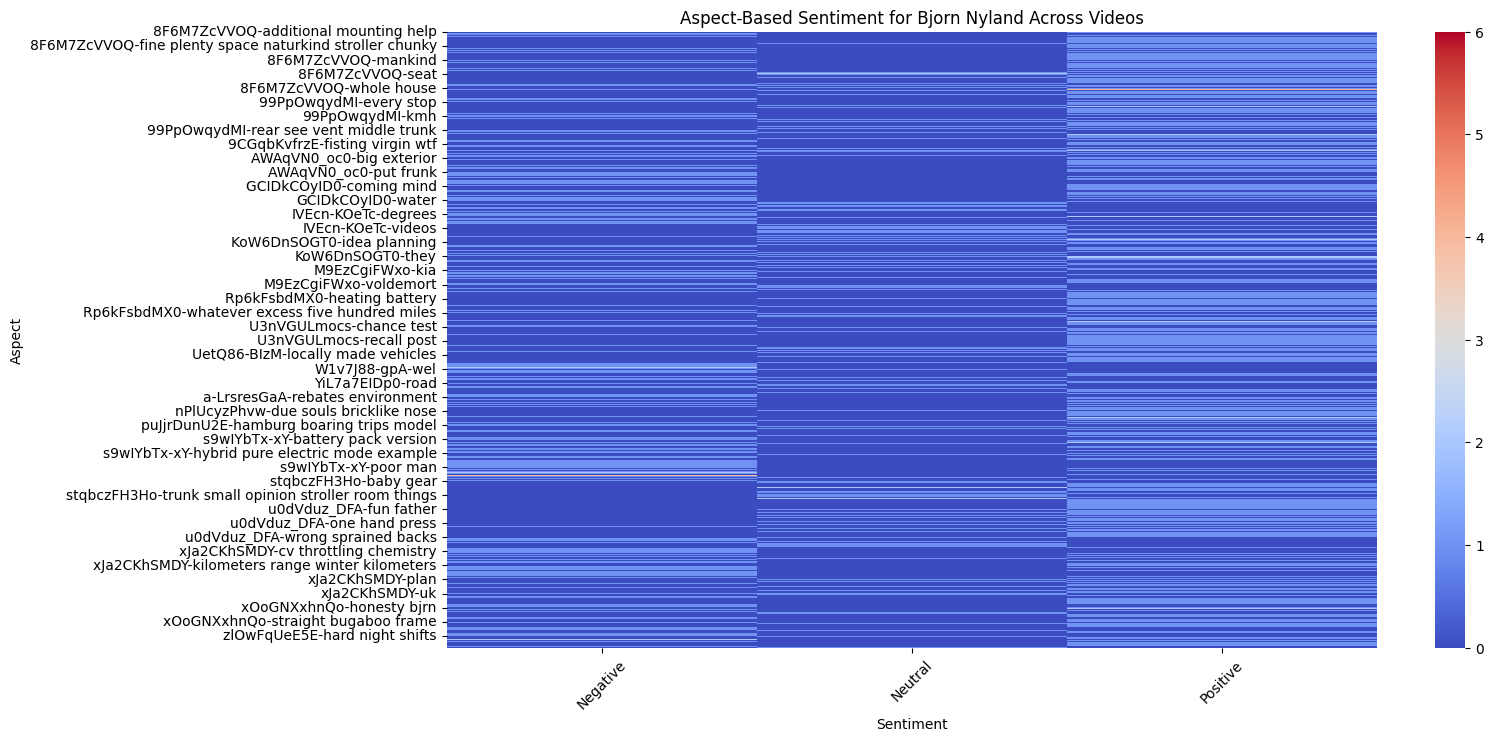

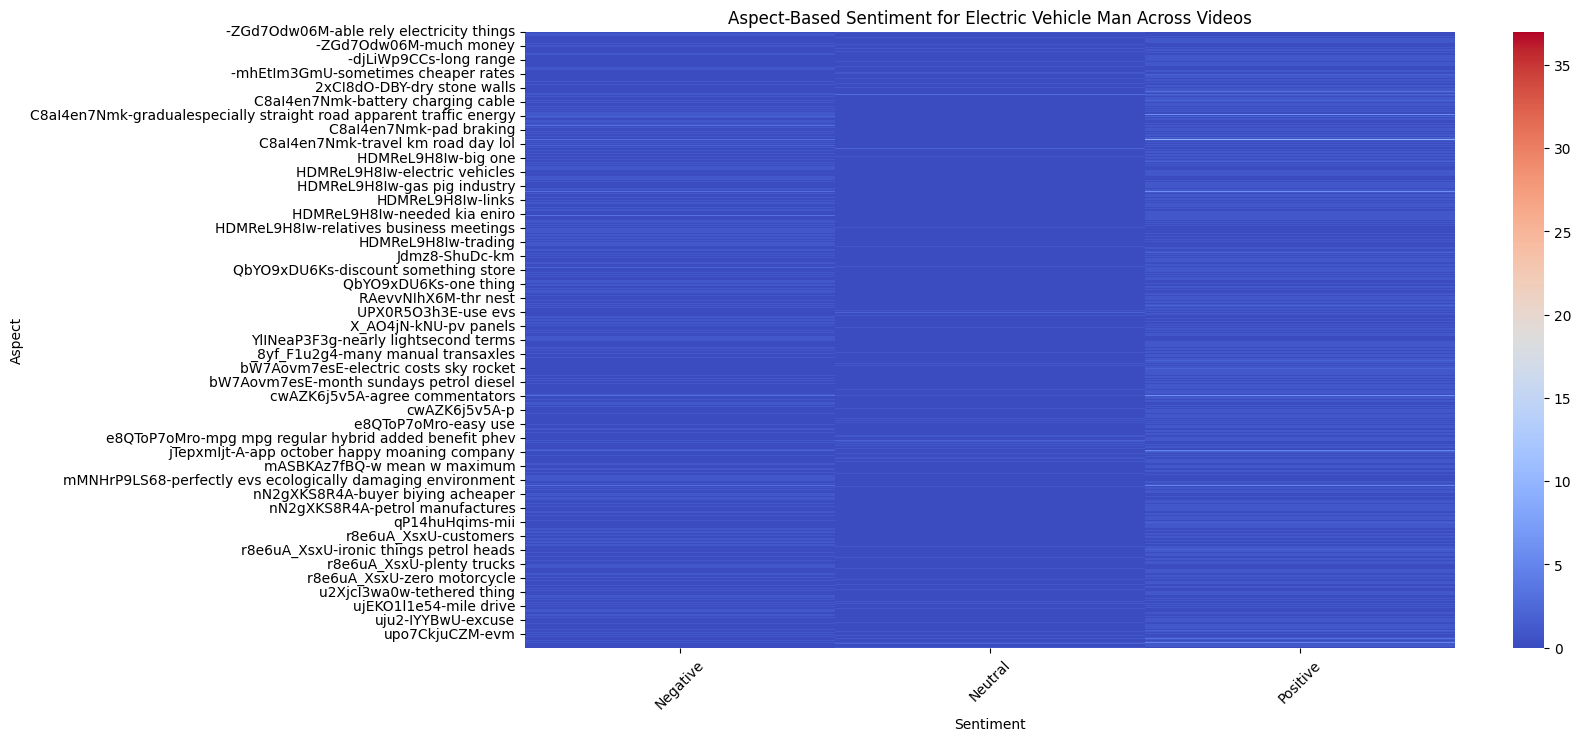

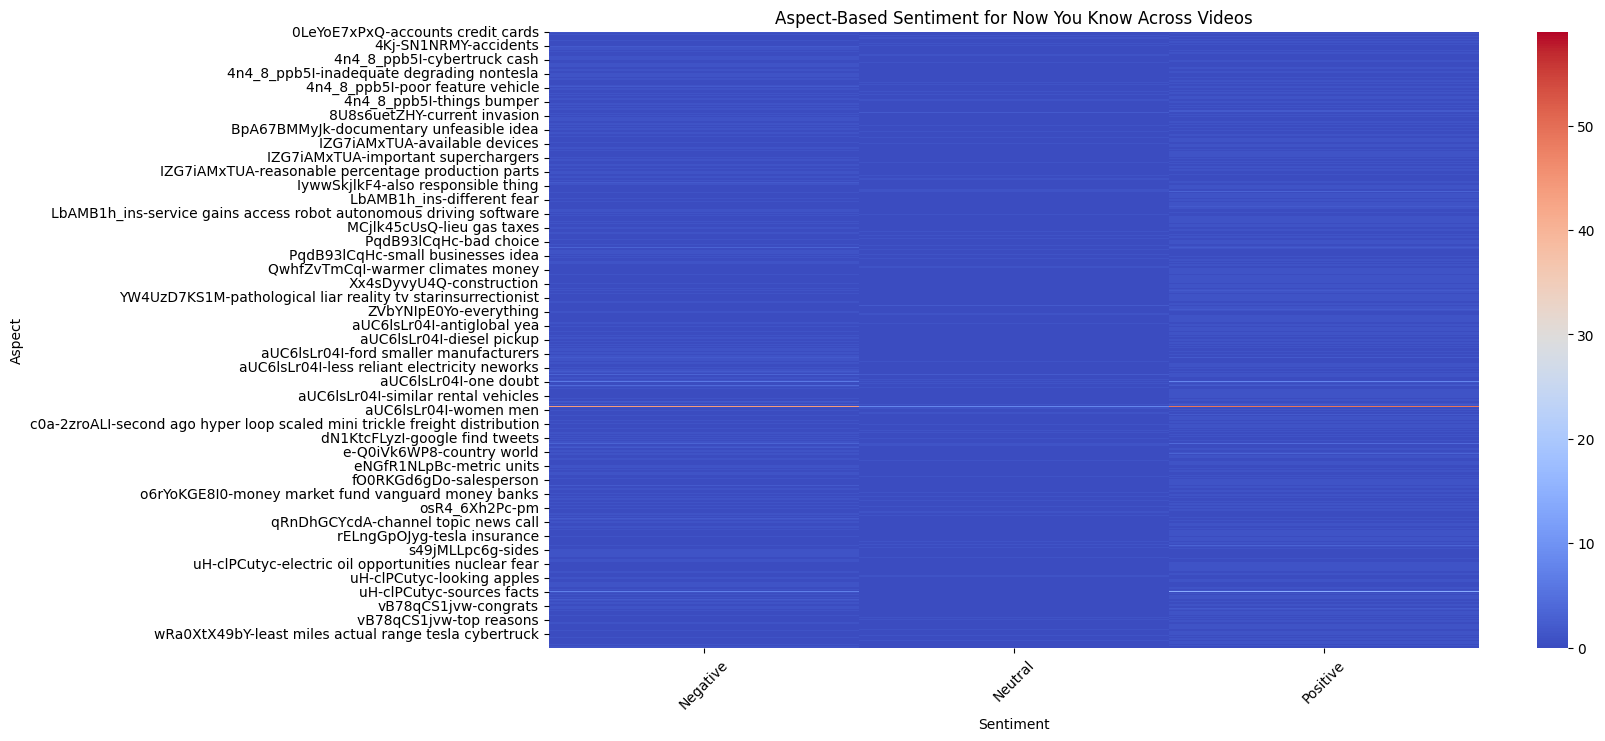

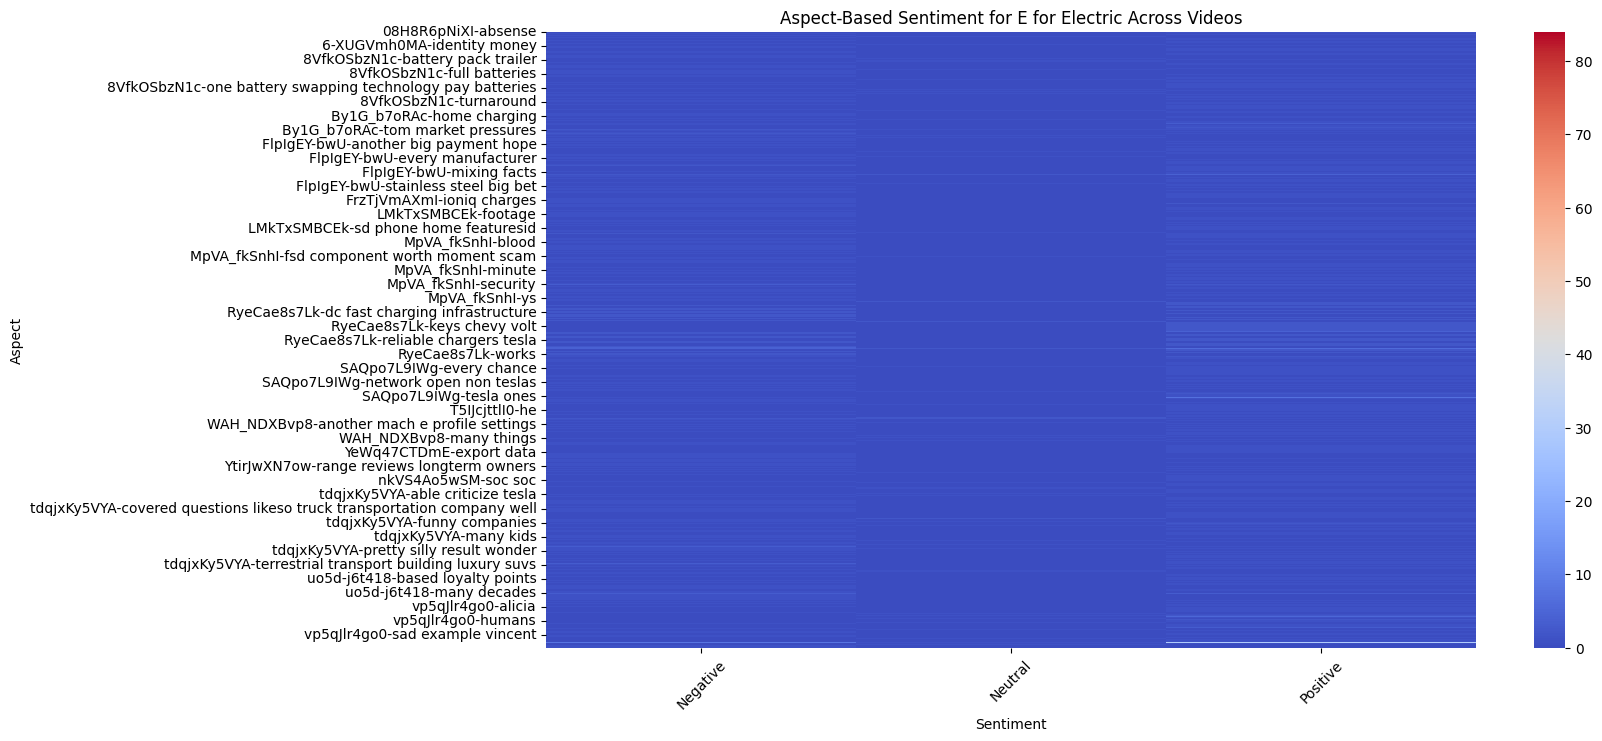

In [27]:
# for creator in df["channel"].unique():
#     creator_df = df[df["channel"] == creator].explode("aspects")
#     aspect_video_sentiment = creator_df.groupby(["video_id", "aspects", "sentiment_bart"]).size().unstack(fill_value=0)
#     plt.figure(figsize=(15, 8))
#     sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=True, fmt="d")
#     plt.title(f"Aspect-Based Sentiment for {creator} Across Videos")
#     plt.xlabel("Sentiment")
#     plt.ylabel("Aspect")
#     plt.xticks(rotation=45)
#     plt.show()

for creator in df["channel"].unique():
    if 'extracted_aspects' in df.columns:
        creator_df = df[df["channel"] == creator].explode("extracted_aspects")
        aspect_video_sentiment = creator_df.groupby(["video_id", "extracted_aspects", "sentiment_roberta"]).size().unstack(fill_value=0)
        plt.figure(figsize=(15, 8))
        sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
        plt.title(f"Aspect-Based Sentiment for {creator} Across Videos")
        plt.xlabel("Sentiment")
        plt.ylabel("Aspect")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column 'extracted_aspects' not found for creator {creator}")

In [28]:
aspect_video_sentiment.to_csv("TD_IDF_aspect_video_sentiment_roberta.csv", index=True)

# ROBERTA

**ROBERTA: Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)**

In [50]:
df = pd.read_csv(r"C:\Users\koole\Documents\9) PLP Practice Module\Use Topics\For Chen Jia\TD-IDF Extracted Aspects_Roberta_BART_Vader\ROBERTA_TD-IDF\New\comment_sentiment_roberta_PLP3.csv")

In [53]:
df.columns

Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment',
       'cleaned_text', 'extracted_aspects', 'sentiment_roberta'],
      dtype='object')

In [57]:
print(df['extracted_aspects'].head(10))


0                                                   []
1     ['tesla', 'prices', 'big question', 'batteries']
2                                                   []
3                              ['vietnamese electric']
4                   ['latin american country vietnam']
5     ['trust', 'highly contradictory reviews', 'nda']
6                                                   []
7                                                   []
8    ['vf boring design copied tesla screen interio...
9                                                   []
Name: extracted_aspects, dtype: object


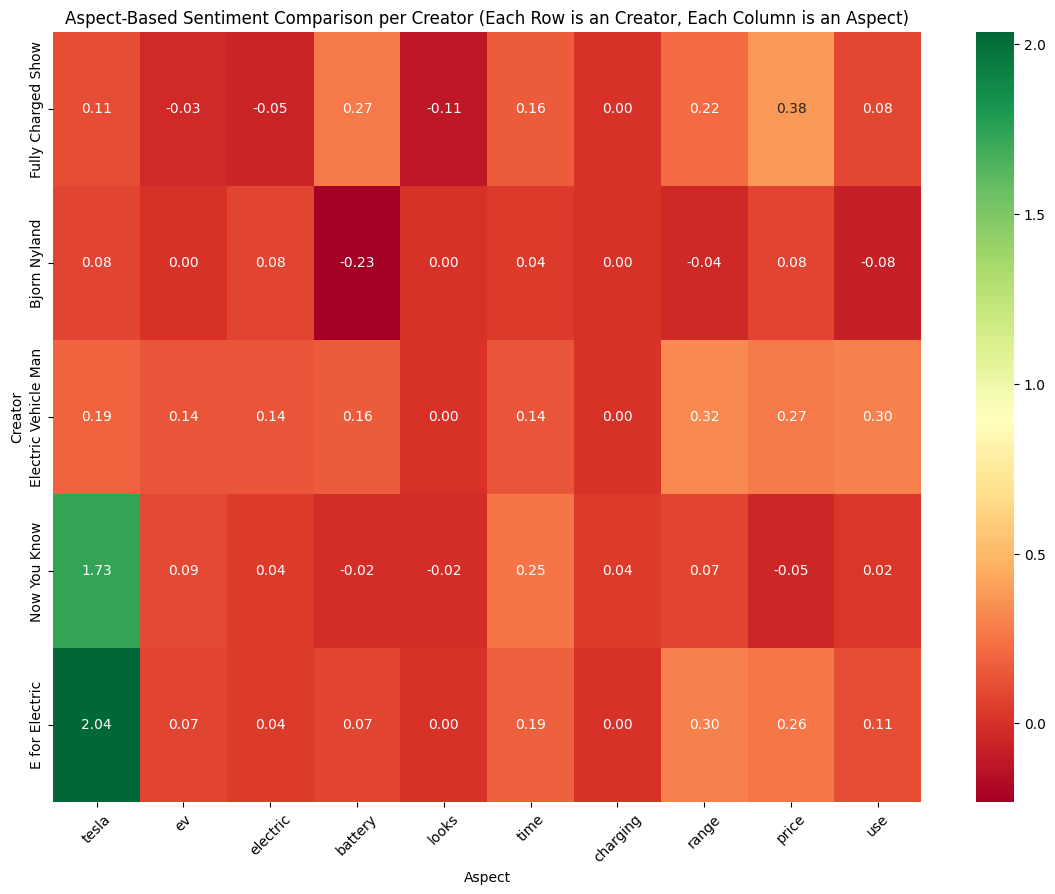

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to store the results
aspect_sentiment_matrix = pd.DataFrame()

import ast
df['extracted_aspects'] = df['extracted_aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Iterate through each creator and calculate aspect sentiment for each video
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    creator_aspect_sentiment = []

    for video_id in creator_df['video_id'].unique():
        video_comments = creator_df[creator_df['video_id'] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_aspects}

        # Update sentiment counts for each aspect in each comment
        for comment, sentiment in zip(video_comments['extracted_aspects'], video_comments['sentiment_roberta']):
            for aspect in comment:
                if aspect in aspect_sentiments:
                    aspect_sentiments[aspect] += 1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0

        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

    # Convert the creator_aspect_sentiment list to a DataFrame
    creator_aspect_sentiment_df = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)

    # Add the DataFrame for this creator to the main aspect_sentiment_matrix
    aspect_sentiment_matrix[creator] = creator_aspect_sentiment_df.mean(axis=0)  # You can use mean or any other aggregation method


# Plot the heatmap with float formatting
plt.figure(figsize=(14, 10))
sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Creator, Each Column is an Aspect)")
plt.xlabel('Aspect')
plt.ylabel('Creator')
plt.xticks(rotation=45)
plt.show()

In [59]:
# Save the aspect sentiment matrix to CSV
aspect_sentiment_matrix.T.to_csv("TF_IDF_aspect_sentiment_per_creator_roberta.csv", index=True)

In [30]:
creator_aspect_sentiment_df.to_csv("TD_IDF_creator_aspect_sentiment_df_roberta.csv", index=True)

**ROBERTA: Heatmap per Creator Per Aspect Per Video (in one Heatmap)** 

Top Aspects from TF-IDF: ['tesla', 'ev', 'electric', 'battery', 'looks', 'time', 'charging', 'range', 'price', 'use']


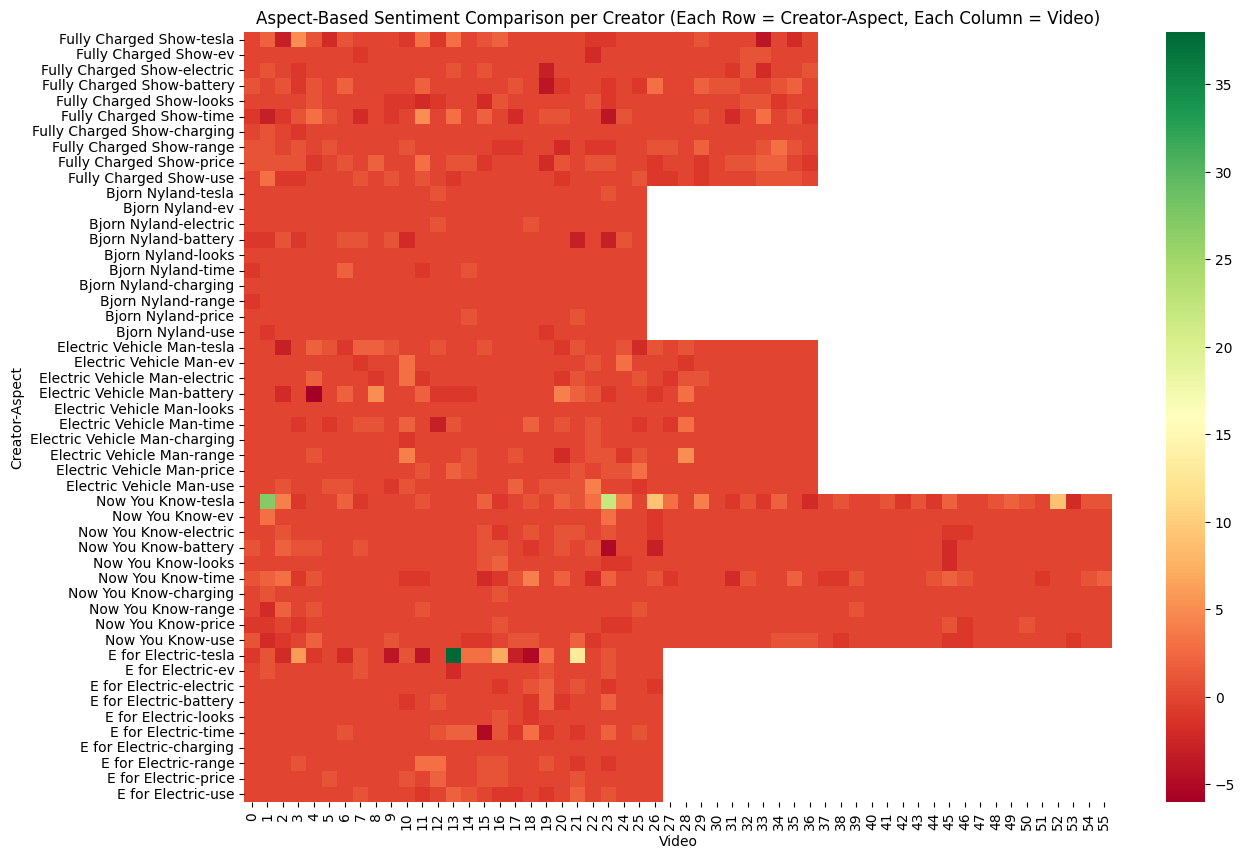

In [32]:
# Extract top-ranked aspects dynamically using TF-IDF
top_aspects = extract_top_aspects_tfidf(df["cleaned_text"].tolist())

# Print extracted top aspects for debugging
print("Top Aspects from TF-IDF:", top_aspects)

# Explode the extracted aspects column for proper analysis
df_exploded = df.explode("extracted_aspects").dropna(subset=["extracted_aspects"])

# Initialize a list to store aspect sentiment data for each creator and video
aspect_sentiment_matrix = []

# Loop through each creator
for creator in df["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df["video_id"].unique():
        video_comments = creator_df[creator_df["video_id"] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_aspects}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments["extracted_aspects"], video_comments["sentiment_roberta"]):
            if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
                # Increment or decrement based on sentiment
                aspect_sentiments[aspects] += (
                    1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0
                )

        # Append sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

    # Convert the list into a DataFrame for this creator and append to matrix
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)
    aspect_sentiment_matrix.append(creator_df_sentiment)

# Concatenate all creator sentiment matrices (horizontally) with labels
aspect_sentiment_matrix = pd.concat(aspect_sentiment_matrix, axis=1, keys=df["channel"].unique())

# Plot the overall aspect sentiment matrix
plt.figure(figsize=(14, 10))
#sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
sns.heatmap(aspect_sentiment_matrix.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row = Creator-Aspect, Each Column = Video)")
plt.xlabel("Video")
plt.ylabel("Creator-Aspect")
plt.show()


In [33]:
aspect_sentiment_matrix.to_csv("TD_IDF_aspect_sentiment_matrix_roberta.csv", index=True)

**ROBERTA: Heatmap per Creator Per Aspect Per Video (One Heatmap Per Creator)** 

In [34]:
# Ensure 'extracted_aspects' is a list before exploding
df['extracted_aspects'] = df['extracted_aspects'].apply(lambda x: x if isinstance(x, list) else [x] if pd.notna(x) else [])

# Explode the 'extracted_aspects' column
df_exploded = df.explode("extracted_aspects")

# Ensure 'extracted_aspects' remains a list
df_exploded['extracted_aspects'] = df_exploded['extracted_aspects'].apply(lambda x: [x] if isinstance(x, str) and x else [])

# Print to verify
print(df_exploded[['channel','extracted_aspects', 'sentiment_roberta']].head(10))

              channel                 extracted_aspects sentiment_roberta
0  Fully Charged Show                                []          Positive
1  Fully Charged Show                           [tesla]          Negative
1  Fully Charged Show                          [prices]          Negative
1  Fully Charged Show                    [big question]          Negative
1  Fully Charged Show                       [batteries]          Negative
2  Fully Charged Show                                []          Negative
3  Fully Charged Show             [vietnamese electric]          Positive
4  Fully Charged Show  [latin american country vietnam]          Positive
5  Fully Charged Show                           [trust]          Positive
5  Fully Charged Show    [highly contradictory reviews]          Positive


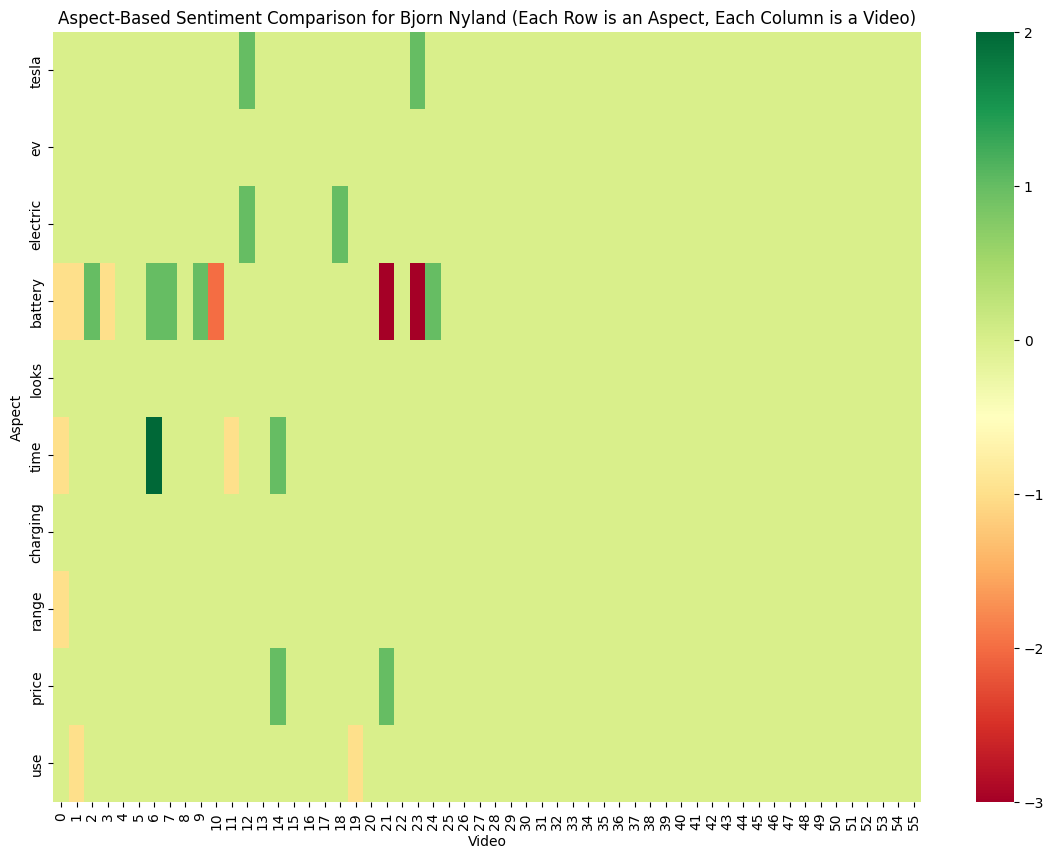

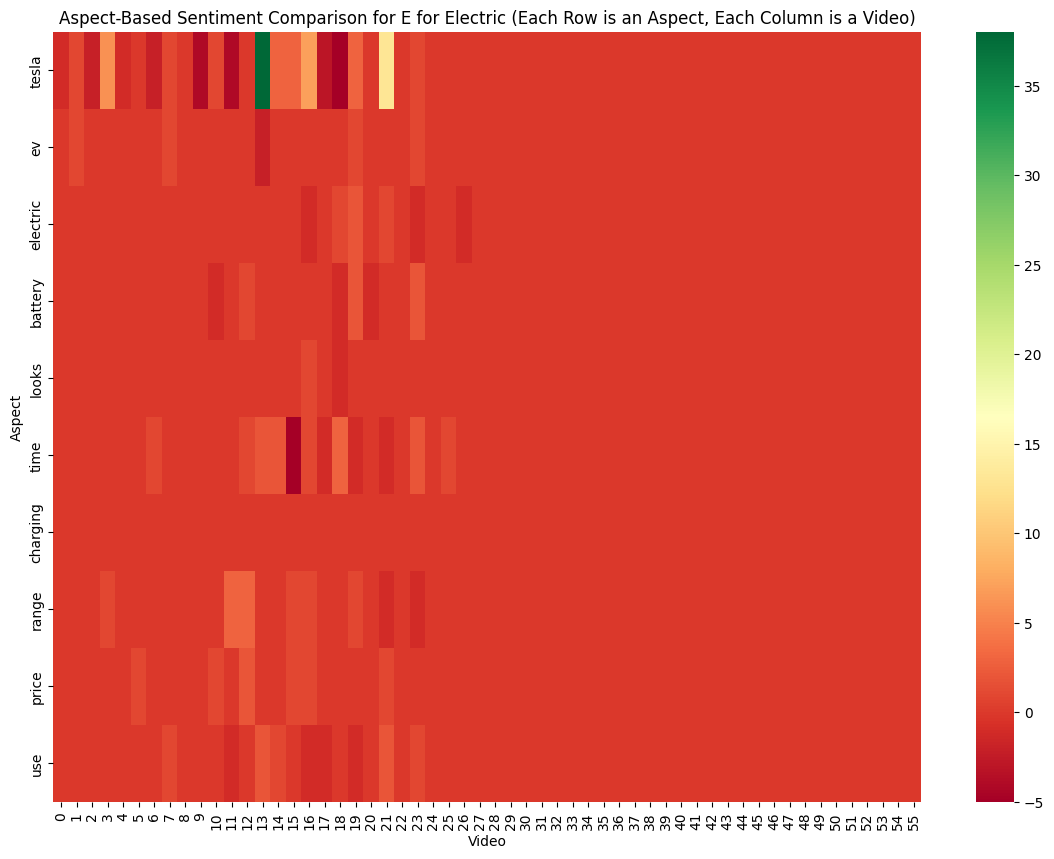

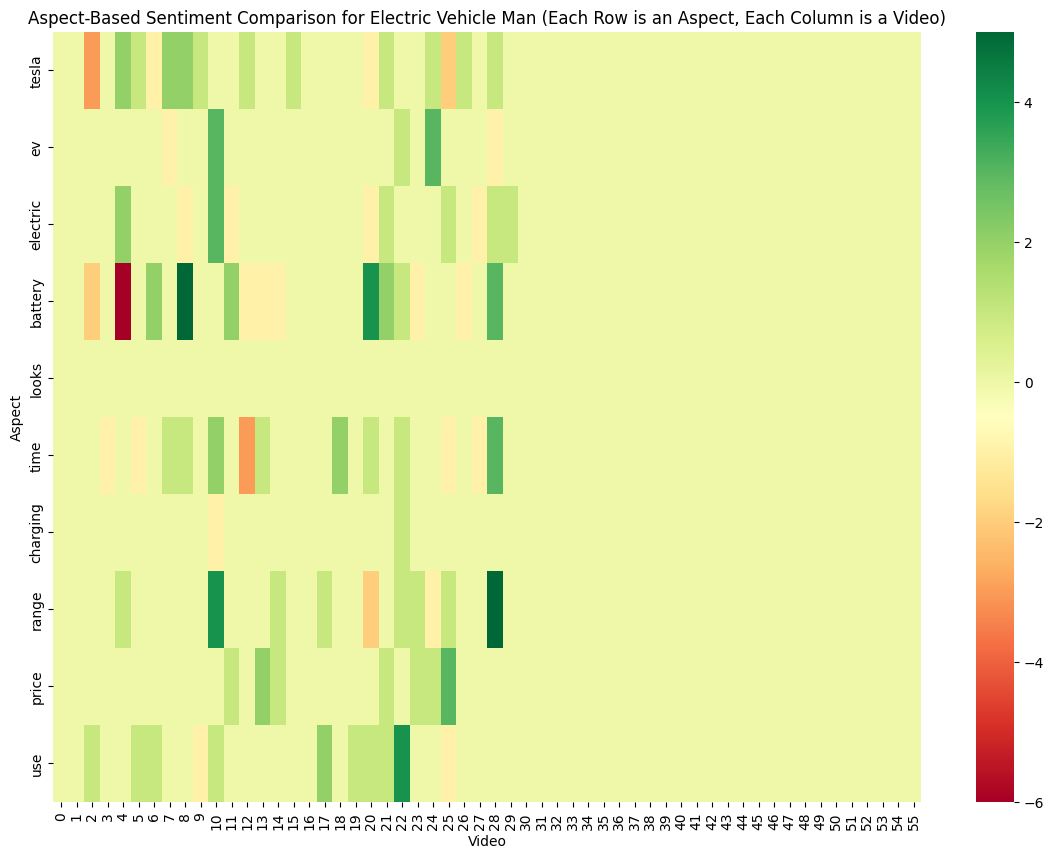

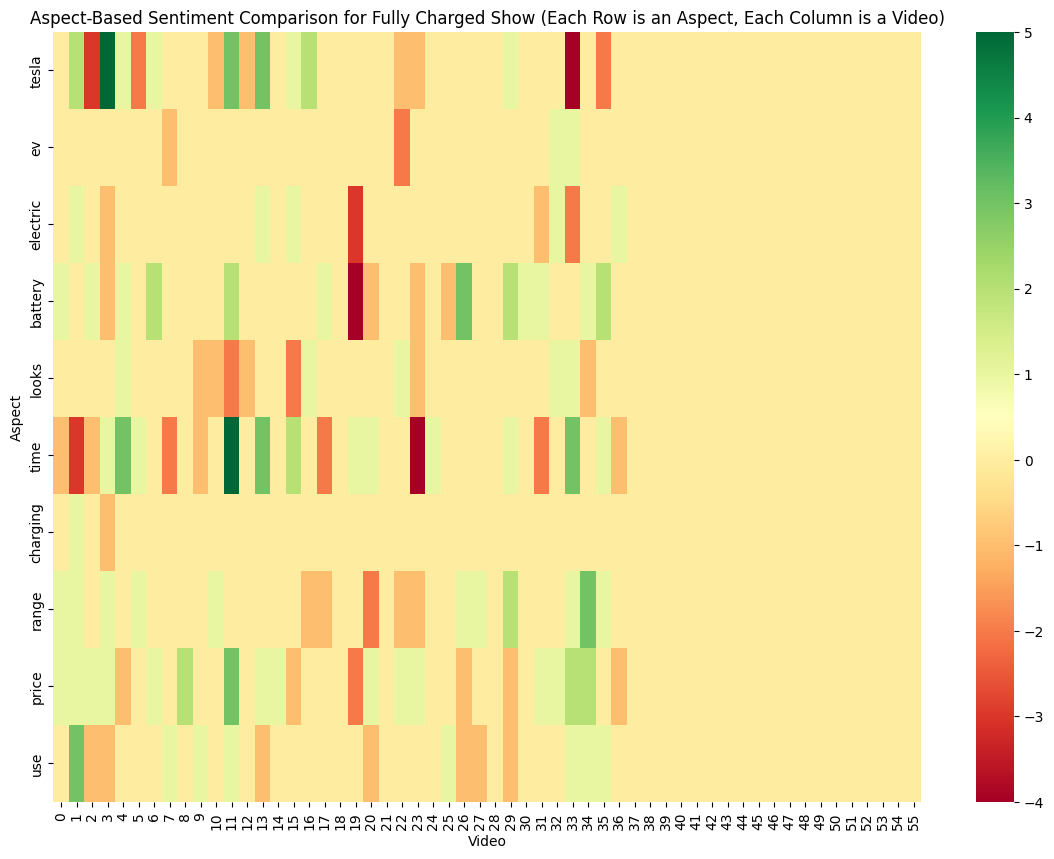

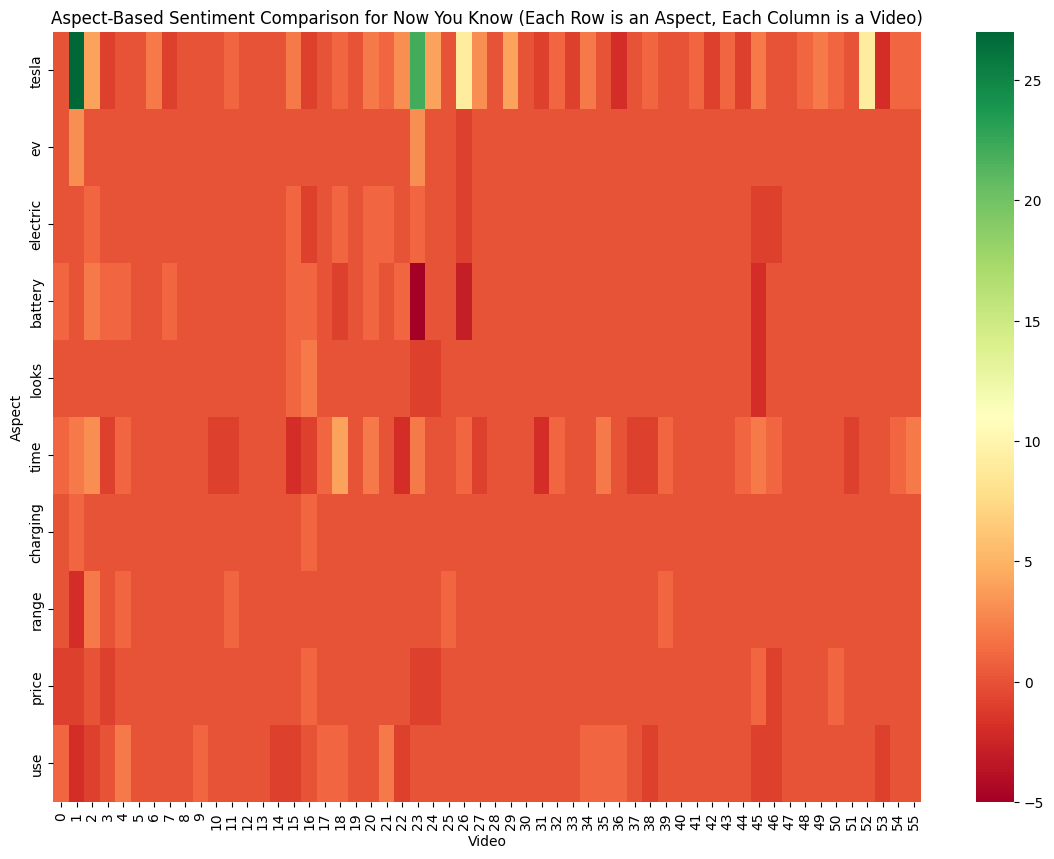

In [45]:
# Initialize a matrix for storing aspect sentiment data for each creator and video
aspect_sentiment_matrix = []

# Loop through each creator
for creator in df['channel'].unique():
    creator_df = df_exploded[df_exploded['channel'] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df['video_id'].unique():
        video_comments = creator_df[creator_df['video_id'] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_aspects}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments['extracted_aspects'], video_comments['sentiment_roberta']):
            for aspect in aspects:
                if aspect in aspect_sentiments:  # Ensure aspect is in top extracted aspects
                    # Increment or decrement based on sentiment
                    aspect_sentiments[aspect] += 1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0

        # Append the sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

    # Add the creator's aspect sentiment data to the matrix
    aspect_sentiment_matrix.append(creator_aspect_sentiment)

# Convert the matrix into a DataFrame, ensuring each video has the same number of columns
max_videos = max(len(creator_aspect_sentiment) for creator_aspect_sentiment in aspect_sentiment_matrix)

# Fill with NaNs for creators with fewer videos
for idx, creator_sentiment in enumerate(aspect_sentiment_matrix):
    while len(creator_sentiment) < max_videos:
        creator_sentiment.append([0] * len(top_aspects))  # Fill missing video rows with zeros

# Convert into DataFrame, where each row corresponds to an aspect, and each column to a video
aspect_sentiment_matrix_df = pd.DataFrame(aspect_sentiment_matrix, 
                                          columns=[f"Video {i+1}" for i in range(max_videos)], 
                                          index=df['channel'].unique())

# Now plot for each creator's sentiment data
for creator, sentiment_data in zip(df['channel'].unique(), aspect_sentiment_matrix):
    creator_sentiment_df = pd.DataFrame(sentiment_data, columns=top_aspects)
    
    # Plot the aspect sentiment for this specific creator
    plt.figure(figsize=(14, 10))
    #sns.heatmap(creator_sentiment_df.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
    sns.heatmap(creator_sentiment_df.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
    plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row is an Aspect, Each Column is a Video)")
    plt.xlabel('Video')
    plt.ylabel('Aspect')
    plt.show()


In [36]:
aspect_sentiment_matrix_df.to_csv("TD_IDF_aspect_sentiment_matrix_df_roberta.csv", index=True)

**ROBERTA: Bar Plot: Total Number of Positive Comments per Creator**

C:\Users\koole\AppData\Local\Temp\ipykernel_24596\169250631.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")


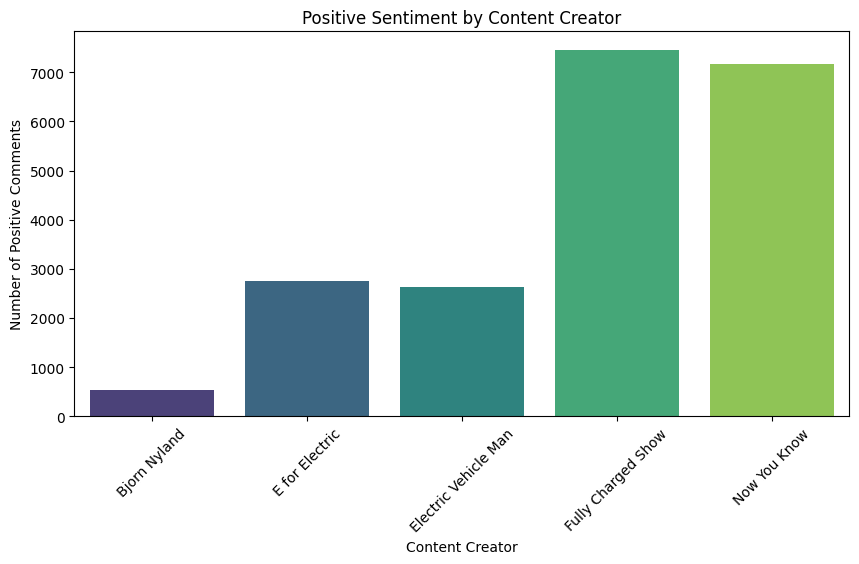

In [37]:
# Count the number of positive comments per creator
positive_comments_per_creator = df[df['sentiment_roberta'] == 'Positive'].groupby('channel').size()

# Plotting the number of positive comments per creator
plt.figure(figsize=(10, 5))
sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
plt.title("Positive Sentiment by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.show()

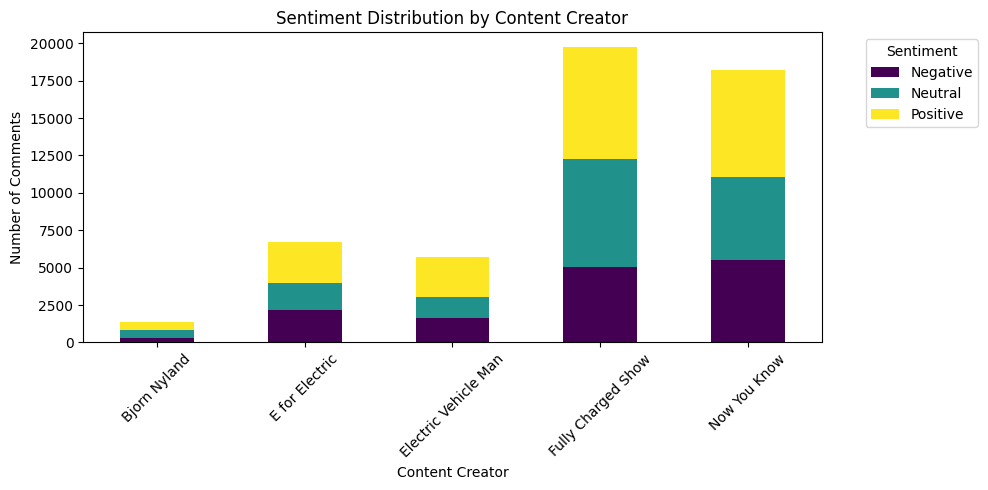

In [38]:
# Count the number of comments per sentiment per creator
comments_per_creator_sentiment = df.groupby(['channel', 'sentiment_roberta']).size().unstack(fill_value=0)

# Plotting the number of comments per sentiment (Positive, Negative, Neutral) per creator
comments_per_creator_sentiment.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="viridis")

plt.title("Sentiment Distribution by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
comments_per_creator_sentiment.to_csv("TD_IDF_comments_per_creator_sentiment_roberta.csv", index=True)

**ROBERTA: Time Series: Number of Positive Comments Over Time per Creator**

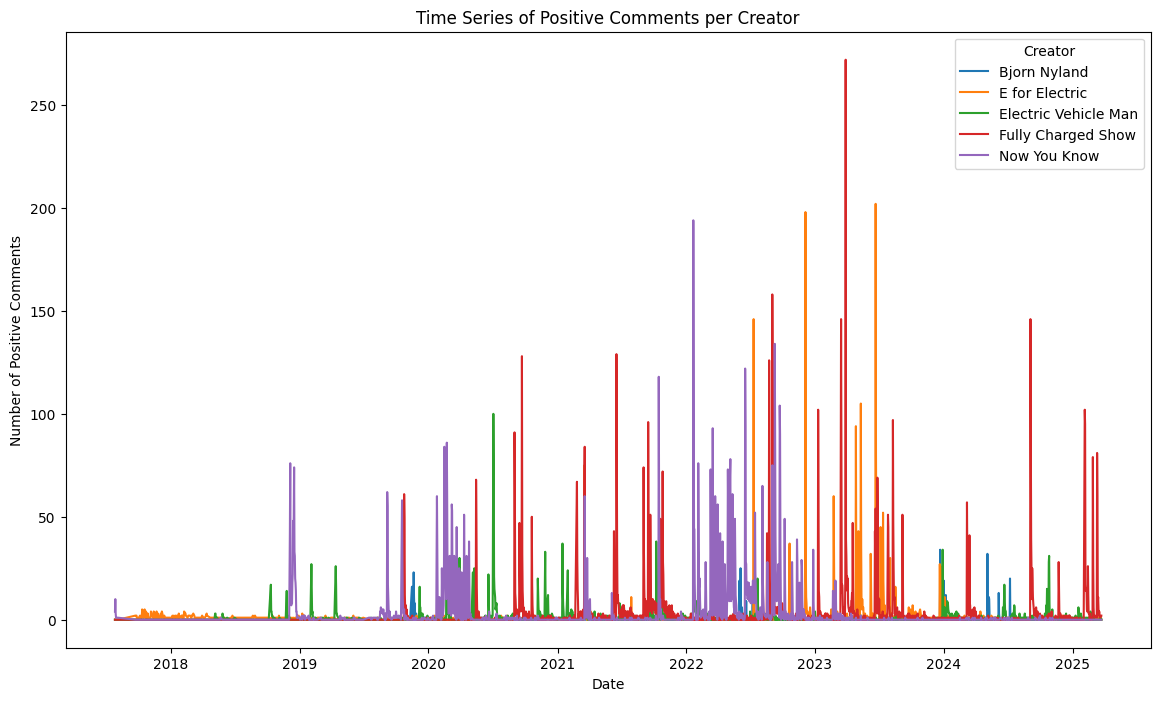

In [40]:
# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Time series of the number of positive comments received per creator
positive_comment_time_series = df[df['sentiment_roberta'] == 'Positive'].groupby(['date', 'channel']).size().unstack(fill_value=0)
positive_comment_time_series.plot(figsize=(14, 8), title="Time Series of Positive Comments per Creator")
plt.ylabel('Number of Positive Comments')
plt.xlabel('Date')
plt.legend(title="Creator")
plt.show()

In [41]:
positive_comment_time_series.to_csv("TD_IDF_positive_comment_time_series_roberta.csv", index=True)

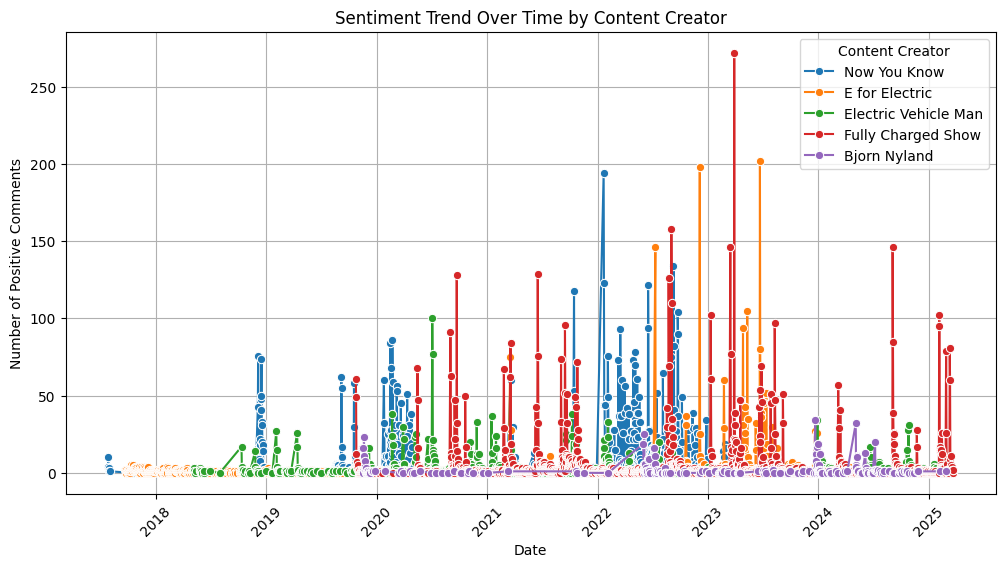

In [42]:
# Sentiment Distribution per Aspect
aspect_sentiment = df.explode("extracted_aspects").groupby(["extracted_aspects", "sentiment_roberta"]).size().unstack(fill_value=0)

# Compare Content Creators based on Sentiment
creator_sentiment = df.groupby(["channel", "sentiment_roberta"]).size().unstack(fill_value=0)

# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Aggregate sentiment counts per date and channel
sentiment_counts = df.groupby(["date", "channel"])["sentiment_roberta"].value_counts().unstack(fill_value=0).reset_index()

# Convert "date" back to datetime type
sentiment_counts["date"] = pd.to_datetime(sentiment_counts["date"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_counts, x="date", y="Positive", hue="channel", marker="o")

plt.title("Sentiment Trend Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()


C:\Users\koole\AppData\Local\Temp\ipykernel_24596\425896429.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="matched_aspects", y="Count", hue="Sentiment", palette="Set2", ci=None)


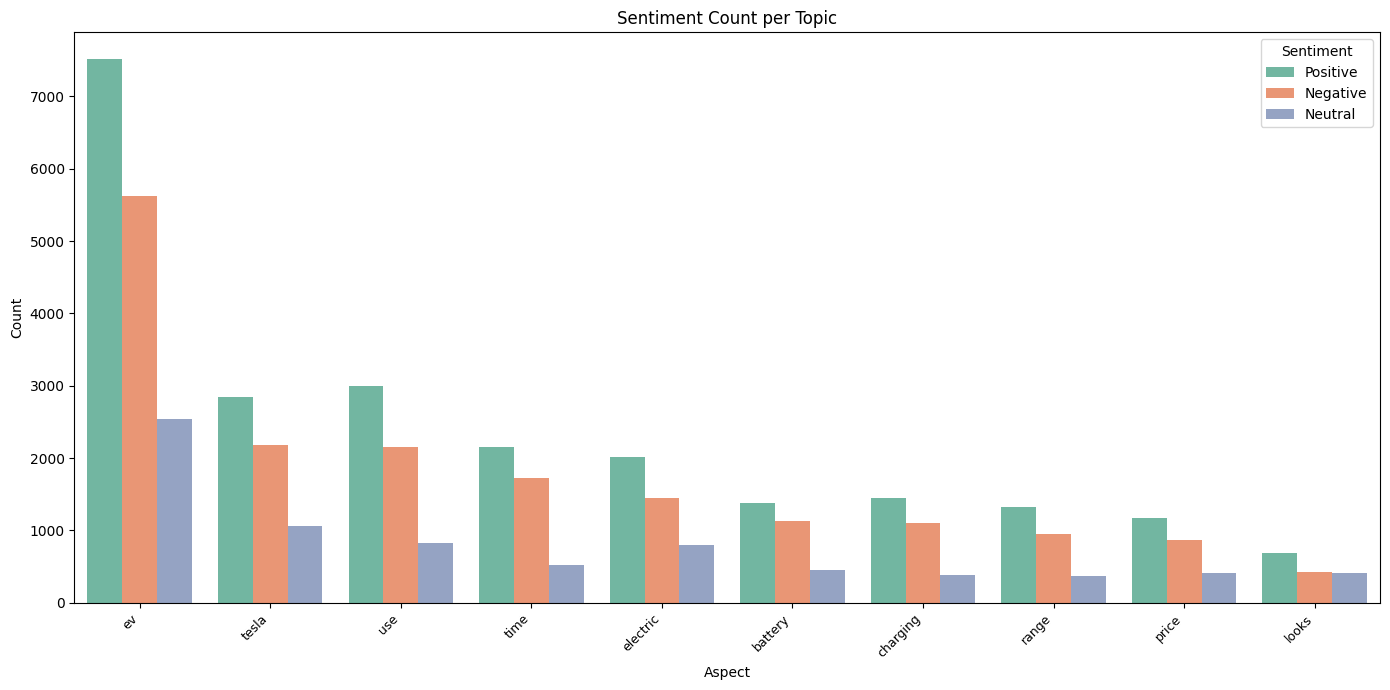

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(r"TD_IDF_topic_sentiment_per_creator_roberta.csv")

# Group by topic and aggregate sentiment counts
df_grouped = df.groupby("matched_aspects", as_index=False)[["Positive", "Negative", "Neutral"]].sum()

# Optional: Sort by total count
df_grouped["Total"] = df_grouped[["Positive", "Negative", "Neutral"]].sum(axis=1)
df_grouped = df_grouped.sort_values("Total", ascending=False)

# Melt for plotting
df_melted = df_grouped.melt(id_vars="matched_aspects", 
                            value_vars=["Positive", "Negative", "Neutral"],
                            var_name="Sentiment", value_name="Count")

# Plot grouped bar chart without error bars
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="matched_aspects", y="Count", hue="Sentiment", palette="Set2", ci=None)

plt.title("Sentiment Count per Topic")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel("Aspect")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
